# Model Training

## Table of Contents
- Data Preparation
- Modelling
    - ARIMA
    - Random Forest
    - XGBoost
- Comparison of Models
- Results

<br>

---

### Data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/cleaned_df_v2.csv", index_col=False)
df = df.iloc[: , 1:]

# convert date
df['year_month'] = pd.to_datetime(df['year_month'])
df['year'] = df['year_month'].dt.year
df['month'] = df['year_month'].dt.month

In [ ]:
from sklearn.model_selection import train_test_split

features = ['year', 'month', 'us_state', 'make', 'phone_series',  'model_family','model_age_months', 
            'predecessor', 'successor', 'model', 'sku', 'sku_no_colour', 'colour', 'size', 'claims', 
            'ir_rate_swap', 'ir_rate_replacement', 'ir_rate_monthly', 'churn_rate'] # 19 features
target = 'closing_subs_monthly'
categorical_cols = ["us_state", "make", "phone_series", "model_family", "colour", "size"]

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3244
    )

X_train.head()

,year,month,us_state,make,phone_series,model_family,model_age_months,predecessor,successor,model,sku,sku_no_colour,colour,size,claims,ir_rate_swap,ir_rate_replacement,ir_rate_monthly,churn_rate
6615,2023,6,Nevada,Apple,IPHONE 12,APPLE IPHONE 12 PRO MAX,31,APPLE IPHONE 11 PRO MAX,APPLE IPHONE 13 PRO MAX,IPHONE 12 PRO MAX 5G 256GB GRAPHITE,IPH12PRM5G256GRY,IPH12PRM5G256,Gray,256,3.0,0.0,0.0,0.001585,0.049128
9440,2023,5,Nevada,Apple,IPHONE XR,APPLE IPHONE XR,55,APPLE IPHONE X,APPLE IPHONE 11,IPHONE XR 64GB BLACK,IPHXR64BLK,IPHXR64,Black,64,0.0,0.0,0.0,0.000000,0.055838
1549,2022,12,Texas,Oppo,OPPO A90,OPPO A94,21,First Model,Last Model,A94 128GB SILVER,A94128SIL,A94128,Silver,128,0.0,0.0,0.0,0.000000,0.073171
10717,2019,9,Nevada,Samsung,SAMSUNG GALAXY NOTE 9,SAMSUNG GALAXY NOTE 9,13,First Model,Last Model,GALAXY NOTE 9 128GB BLACK,NOTE9128BLK,NOTE9128,Black,128,16.0,0.0,0.0,0.002614,0.035778
3034,2021,4,California,Samsung,GALAXY S21,SAMSUNG GALAXY S21 PLUS,14,SAMSUNG GALAXY S20 PLUS,SAMSUNG GALAXY S22 PLUS,GALAXY S21 PLUS 5G 256GB BLACK,GXYS21P5G256BLK,GXYS21P5G256,Black,256,0.0,0.0,0.0,0.000000,0.027237


<br>

---

## Time series model: ARIMA (AutoRegressive Integrated Moving Average) model

Data preparation

In [4]:
# Split the data into training and test sets
train_data = df[df['year_month'] < '2024-01-01']  # Data up to December 2023
test_data = df[df['year_month'] >= '2024-01-01']  # Data from January 2024 onwards

In [5]:
train_data.head()

,year_month,us_state,make,phone_series,model_family,predecessor,successor,model_age_months,model,sku,...,size,closing_subs_monthly,claims,ir_rate_swap,ir_rate_replacement,ir_rate_monthly,churn_rate,churn,year,month
0,2019-01-01,California,Oppo,OPPO A10,OPPO A12,First Model,OPPO A15,14,A12 32GB BLUE,A12BLU,...,32,137,0.0,0.0,0.0,0.0,0.0,0,2019,1
1,2019-02-01,California,Oppo,OPPO A10,OPPO A12,First Model,OPPO A15,15,A12 32GB BLUE,A12BLU,...,32,152,0.0,0.0,0.0,0.0,0.0,0,2019,2
2,2019-03-01,California,Oppo,OPPO A10,OPPO A12,First Model,OPPO A15,16,A12 32GB BLUE,A12BLU,...,32,162,0.0,0.0,0.0,0.0,0.0,0,2019,3
3,2019-04-01,California,Oppo,OPPO A10,OPPO A12,First Model,OPPO A15,17,A12 32GB BLUE,A12BLU,...,32,173,0.0,0.0,0.0,0.0,0.0,0,2019,4
4,2019-05-01,California,Oppo,OPPO A10,OPPO A12,First Model,OPPO A15,18,A12 32GB BLUE,A12BLU,...,32,179,0.0,0.0,0.0,0.0,0.0,0,2019,5


In [6]:
# Sort by 'year' and 'month'
df['year_month'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Group data by month (sum or average claims)
monthly_data = df.groupby('year_month')['claims'].sum()
monthly_data.head()

year_month
2019-01-01     633.112710
2019-02-01     525.608554
2019-03-01     961.884443
2019-04-01    1101.394905
2019-05-01     948.019294
Name: claims, dtype: float64

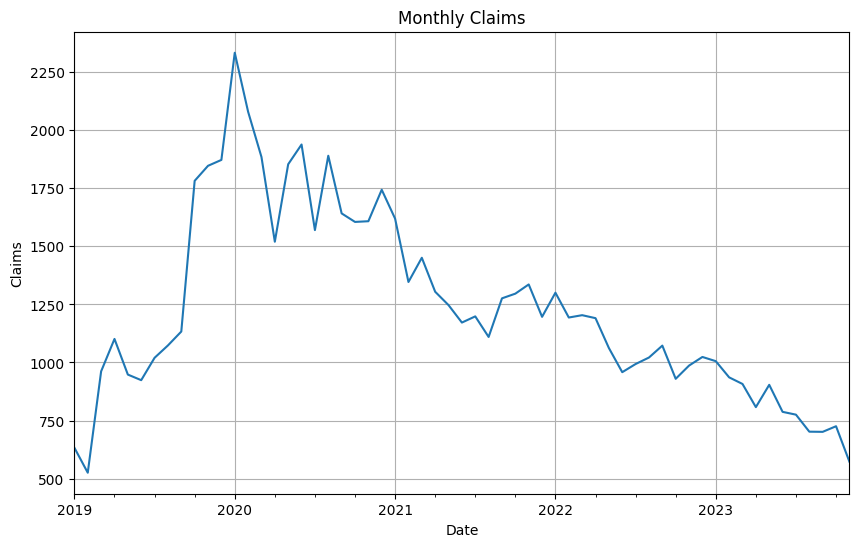

In [7]:
# Plot Claims VS Date
plt.figure(figsize=(10, 6))
monthly_data.plot()
plt.title('Monthly Claims')
plt.xlabel('Date')
plt.ylabel('Claims')
plt.grid(True)
plt.show()

Overall, we see that the number of claims decreases as time increases. 

In [8]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(monthly_data)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If p-value < 0.05, the series is stationary

ADF Statistic: -1.0084416352340653
p-value: 0.750172970005367


In [9]:
# Differencing the data to make it stationary
monthly_data_diff = monthly_data.diff().dropna()

# Check stationarity again
result_diff = adfuller(monthly_data_diff)
print(f'ADF Statistic (Differenced): {result_diff[0]}')
print(f'p-value (Differenced): {result_diff[1]}')

ADF Statistic (Differenced): -6.751875917279571
p-value (Differenced): 2.937052635838381e-09


Now that the data is stationary (or made stationary), we can fit an ARIMA model.

In [10]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(monthly_data, order=(5, 1, 0))  # p=5, d=1, q=0 (can fine tune)
model_fit = model.fit()

# Summarize the model
model_fit.summary()

/Users/carlychinsekyi/miniconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/carlychinsekyi/miniconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/carlychinsekyi/miniconda3/envs/dev/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 claims   No. Observations:                   59
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -382.305
Date:                Thu, 19 Dec 2024   AIC                            776.610
Time:                        14:28:45   BIC                            788.973
Sample:                    01-01-2019   HQIC                           781.426
                         - 11-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1582      0.119     -1.328      0.184      -0.392       0.075
ar.L2         -0.0354      0.145     -0.244      0.807      -0.319       0.249
ar.L3          0.1619      0.089      1.820      0.069      -0.012       0.336
ar.L4          0.0573      0.130      0.440      0.660      -0.198       0.313
ar.L5         -0.0489      0.127     -0.385      0.700      -0.298       0.200
sigma2      3.104e+04   4197.514      7.395      0.000    2.28e+04    3.93e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                19.69
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

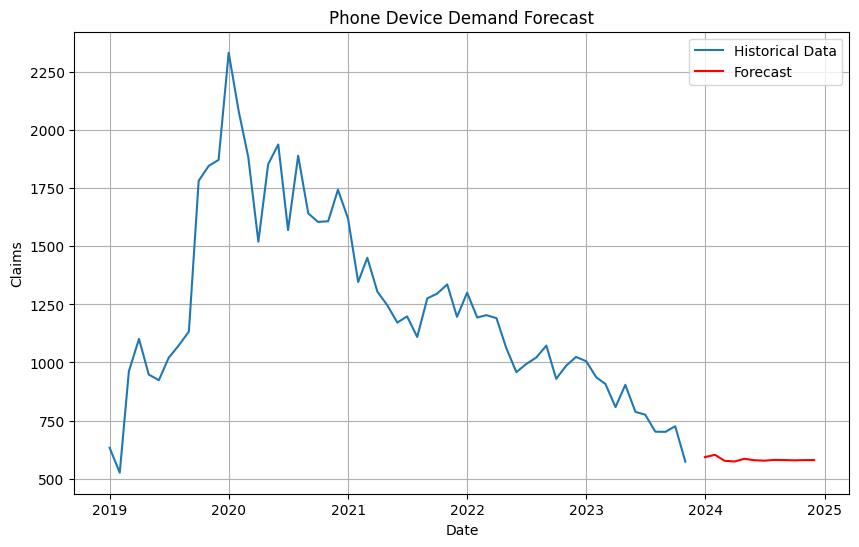

In [11]:
# Forecast for the next 2 months
forecast = model_fit.forecast(steps=12)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data, label='Historical Data')
plt.plot(pd.date_range(monthly_data.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast', color='red')
plt.title('Phone Device Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Claims')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming `test_data` is the actual data for the forecast period and `forecast` is the predicted values
# For example:
test_data = [210, 220]  # Replace with your actual test data
forecast = [215, 225]  # Replace with the forecasted values from your ARIMA model

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data, forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_data, forecast))

# Print the results
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


MAE: 5.0
RMSE: 5.0


Interpretation:
- Mean Absolute Error (MAE):
    - The MAE of 5.0 indicates that, on average, the forecasted values are off by 5 units from the actual values. This is a straightforward measure of the error, showing how far off the predictions are in terms of absolute values, without considering the direction of the error.
    - In practical terms, this means that for each forecasted value, the difference between the actual and predicted value is, on average, 5 units.

- Root Mean Squared Error (RMSE):
    - The RMSE of 5.0 suggests that the forecast error, on average, has a magnitude of 5.0, taking into account the squared differences. Since the MAE and RMSE are identical here, it indicates that the errors are consistent across all data points and are relatively small in magnitude.

<br>

---

## RandomForestRegressor to predict closing_subs_monthly

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  
    ])

# Define the model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42)) 
])

# Model training
model_pipeline.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model_pipeline.predict(X_test)

# Evaluate the model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 1870.7079620144557


<br>

---

## XGBoost

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=3244
    )